# Land Use Land Cover (LULC) Classification for Irrigated Agricultural Land Mapping 

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)

### Background
Land Use and Land Cover (LULC) classification is fundamental for monitoring environmental dynamics, assessing land degradation, and promoting sustainable natural resource management. Accurate and timely information on irrigated and rainfed agricultural systems is also essential for enhancing regional and global food security, optimizing water resource allocation, and informing evidence-based policy decisions. Despite its importance, generating reliable agricultural data remains a persistent challenge, particularly in data-scarce regions. However, recent advancements in remote sensing (RS), machine learning (ML) techniques, and Python programming offer robust, scalable, and cost-effective solutions to address these limitations.

In this initiative, the Digital Earth Africa (DE Africa) Sandbox platform was leveraged to **generate high-resolution LULC maps, as well as irrigated and rainfed area maps** for `Adaa Bishoftu district`, found in the `Oromia regional state`, `Ethiopia`. The classification process integrated Sentinel-2 imagery, field-based ground control points (GCPs), and the Random Forest (RF) algorithm to enhance classification accuracy. This approach highlights the potential of combining cloud-based Earth Observation (EO) platforms with ML algorithms to advance agricultural monitoring and support sustainable land and water management practices across Africa.

This notebook was developed by Digital Innovations for Water Secure Africa (DIWASA) stakeholders in Ethiopia. Key contributors `Jemal Mohammed Hassen`, `Mulugeta Melese Sime`, `Ashebir Haile Tefera`, `Eden Seifu `, and `Tarikuwa Birhane`, whose commitment, teamwork, and shared vision were instrumental in bringing the notebook to fruition. Their work was further reinforced by the guidance and technical support of the Ethiopian International Water Management Institute (IWMI) team, particularly `Dr. Alemseged Tamiru Haile` and `Mr. Ephrem Derso Negash`, whose expertise ensured the scientific quality and successful completion of this initiative. 

## Description 

This notebook demonstrates the creation of an LULC map for irrigated and rainfed agricultural land mapping using a supervised classification technique.  
<span style="color:'red'">The activities of this notebook are:</span>
- Load essential Python packages and functions 
- Import the area of interest and the GCPs and define the analysis parameters
- Connecting using *DE Africa STAC* to loading Sentinel 2 data
- Train and evaluate the random forest classifier for predicting the LULC map
- Generate an irrigated agricultural map  
---

# Getting started 
Loading relevant Python packages and supporting functions for the analysis is the first step. The packages and functions required for the analysis of this session are provided in the cell below.

In [1]:
#Import packages
import numpy as np                       # Handles numerical operations and array-based data 
import pandas as pd
import geopandas as gpd       # Manages and analyzes vector geospatial data (shapefiles, GeoJSON)
import matplotlib.pyplot as plt          # Creates and customizes plots and visualizations
from tqdm.auto import tqdm

from sklearn.ensemble import RandomForestClassifier  #Trains a machine learning model for classification tasks
from sklearn.model_selection import train_test_split  # Splits datasets into training and testing subsets 
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, accuracy_score  # Summarizes model performance with precision, recall, and F1-score

The package deafrica_tools contains several functions that help to load, analyze, and generate output from the DE Africa sandbox.  

In [2]:
from deafrica_tools.dask import create_local_dask_cluster # Sets up local parallel processing for large data tasks

#Custom functions 
from tools.irrigated_functions import display_data, connect_stac, clip_roi, save_roi
from tools.irrigated_functions import sample_lulc_from_composite, predict_lulc_map, plot_lulc_map
from tools.irrigated_functions import irrigation_process, predict_irrigated_rainfed_map
from tools.irrigated_functions import plot_irrigated_rainfed_map, export_classification_summary
from tools.irrigated_functions import compare_map

import warnings            # To manage and control the display of warning messages in Python
warnings.filterwarnings("ignore")  # Suppresses warning messages during code

### Set up a Dask cluster 

This will help keep your memory usage down and conduct the analysis in parallel. The DE Africa recommends opening the Dask processing window to view the different computations that are being executed. To use Dask, set up the local computing cluster using the function below in a code cell. 

In [3]:
# Set up a dask cluster
create_local_dask_cluster()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/nanaboamah89@gmail.com/proxy/8787/status,
Dashboard: /user/nanaboamah89@gmail.com/proxy/8787/status,Workers: 1
Total threads: 4,Total memory: 26.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41935,Workers: 1
Dashboard: /user/nanaboamah89@gmail.com/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 26.21 GiB
Comm: tcp://127.0.0.1:37349,Total threads: 4
Dashboard: /user/nanaboamah89@gmail.com/proxy/40019/status,Memory: 26.21 GiB
Nanny: tcp://127.0.0.1:43417,


2025-10-28 15:03:02,089 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3e16d4c1f37dd5afda0a986af2b92681 initialized by task ('B12-rechunk-transfer-248d3374477019e65ca97a38a83c32e0', 0, 0, 0, 26, 0, 0) executed on worker tcp://127.0.0.1:37349
2025-10-28 15:03:14,365 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f6adcb55bd212f28f5f4e898a26551bf initialized by task ('B02-rechunk-transfer-e8979352e965f821bdebd4a1cd0e730f', 0, 0, 0, 9, 0, 0) executed on worker tcp://127.0.0.1:37349
2025-10-28 15:03:24,071 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3e16d4c1f37dd5afda0a986af2b92681 deactivated due to stimulus 'task-finished-1761663804.0706809'
2025-10-28 15:03:38,139 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a5474866ac1086a60de1fc3c0c3d6d4e initialized by task ('B03-rechunk-transfer-7be5d1d13955b85a15b1d3aff630c583', 0, 0, 0, 22, 0, 0) executed on worker tcp://127.0.0.1:37349
2025-10-28 15:03:49,335 - distributed.shuffle._scheduler

## Analysis parameters
• `path`: The path to the input vector file that we will use in the training (`roi, lulc_gcps, and irrig_gcp`)

• `class_attr`: This is the name of the column in the training points attribute table that contains the class labels.

• `output_crs`: Output spatial reference system (`epsg:32735`).

In [4]:
#Input Datasets
roi_path = 'Data/Adea_Bishoftu_District.geojson'
lulc_gcp_path = 'Data/All_LULC_GCPs_v3_10m.geojson'
irrig_gcp_path = 'Data/Adea_irrigated_rainfed__GCP_8m.geojson'

#Output Filepath
filepath = "Results"

#Saving Geotiffs
output_composite = 'composite_multiband'
predicted_lulc_map = 'lulc_map_predicted'
irrigation_composite = 'lirrigation_map_predicted'
agri_masked = 'agri_masked'
irrigated_rainfed = 'irrigated_rainfed'

#Column to use for classification
class_attr = 'landcover'

#Coordinate Systems to Implement
output_crs='epsg:32735' # WGS84/UTM Zone 37N

### Defining Agricultural Class for LULC Map
### This variable is used later to `mask agricultural areas` for irrigated and rainfed land classification.
AG_CLASS = 1

# Define colors for each class
class_colors = {
        1: '#eaf30c',      # Agriculture
        2: 'darkgreen',    # Forest
        3: '#dc10a5',      # Bareland
        4: '#ff2e07',      # Settlement
        5: 'orange',       # Shrubland
        6: '#4c11ff'       # Waterbody
    }

class_info = {
    1: ("Agriculture", "#eaf30c"),
    2: ("Forest", "#3d6600"),
    3: ("Bareland", "#dc10a5"),
    4: ("Settlement", "#ff2e07"),
    5: ("Shrubland", "#36ff0d"),
    6: ("Waterbody", "#4c11ff"),
}

# Connect to DE Africa STAC and search Sentinel-2 L2A items for your bbox/time
collection_name = "s2_l2a"

# Updated band names based on STAC item inspection
bands = ["B02","B03","B04","B08","B11","B12"]

# Time window - you can adjust. Original was in the future, trying a past range.
time_range = "2024-12-01/2025-04-30" # Adjusted time range

In [5]:
#Setting Up Varables Environments
#path to save files
output_composite = f"{filepath}/{output_composite}"
predicted_lulc_map = f"{filepath}/{predicted_lulc_map}"
irrigation_composite = f"{filepath}/{irrigation_composite}"
agri_masked = f"{filepath}/{agri_masked}"
irrigated_rainfed = f"{filepath}/{irrigated_rainfed}"

# Read input Datasets with GeoPandas and compute bbox for STAC query
roi_gdf = gpd.read_file(roi_path)
gdf_lulc = gpd.read_file(lulc_gcp_path)
gdf_irrig = gpd.read_file(irrig_gcp_path)

# bbox for STAC: [minx, miny, maxx, maxy]
bbox = list(roi_gdf.total_bounds)

# Select columns for the training points
training_points=gdf_lulc[[class_attr,'geometry']] # select attributes

### Preview input data
We can load and preview our input data using geopandas. Visualizing the points on an interactive map helps you confirm their spatial distribution and labeling accuracy before classification.

In [6]:
# Plot first five rows using the head() method
training_points.head()

,landcover,geometry
0,1,"POLYGON ((39.09094 8.75376, 39.09091 8.75375, ..."
1,1,"POLYGON ((39.04107 8.78855, 39.04104 8.78855, ..."
2,1,"POLYGON ((39.044 8.78442, 39.04398 8.78441, 39..."
3,1,"POLYGON ((39.05334 8.77856, 39.05332 8.77855, ..."
4,1,"POLYGON ((39.05539 8.77057, 39.05537 8.77056, ..."


Displaying all training data at once can slow down map rendering. To keep it manageable, let’s visualize the first 200 samples on an interactive map. 

In [7]:
# Preview a limited number of points
display_data(dataset = training_points, 
             rows = 693, 
             color_code = class_colors,
             column = class_attr)

Unique classes found: [1 2 3 4 5 6]


## Connect to DE Africa STAC and search Sentinel-2 data

The SpatioTemporal Asset Catalog (STAC) is a standardized framework and API used to connect DE Africa geospatial datasets based on their spatial and temporal attributes. The DE Africa STAC serves as an API interface, providing access to metadata and download links (https://explorer.digitalearth.africa/stac) for DE Africa datasets. 

The code below connects to the Digital Earth Africa `STAC` catalog, searches for `Sentinel-2 L2A` imagery within a specified `bounding box` and `time range`, and implements a `retry mechanism` to handle connection failures, printing the number of retrieved items.

In [8]:
# Load Sentinel 2 dataset through STAC
composite = connect_stac(collection_id = collection_name, bbox = bbox, time_range = time_range, bands = bands, resolution = 10)

# Clip composite to ROI and ensure CRS consistency
clip_composite = clip_roi(roi_gdf, composite)

# Save composite map
final_composite = save_roi(clip_composite, output_composite, bands)

STAC Attempt 1/5:   0%|          | 0/6 [00:00<?, ?step/s]

/opt/venv/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
Clipping Progress: 100%|██████████| 6/6 [00:01<00:00,  3.01step/s]


Clipping complete. Bands: ['B02', 'B03', 'B04', 'B08', 'B11', 'B12']
Saving composite to: Results/composite_multiband.tif


Stacking bands: 100%|██████████| 6/6 [00:00<00:00, 54236.69band/s]


Writing GeoTIFF (this may take time for large composites)...
Saved composite to: Results/composite_multiband.tif


### Sampling raster pixels under polygons for supervised classification

The function `sample_from_polygons` extracts training data for `supervised classification` by sampling pixel values from a raster image within labeled polygon regions. For each polygon in a `GeoDataFrame`, it masks the raster to extract pixel values from specified bands, `filters out no-data values`, and pairs the valid pixel vectors with corresponding class labels from the polygon's `class` attribute. The function returns two arrays: 
* a feature matrix containing all sampled pixel values and a label vector with corresponding class identifiers,

* creating the structured dataset needed to train a machine learning classifier for image analysis.

### Sampling LULC training data from ground control polygons

The code below prepares and extracts `training samples` for `classification` from the satellite image composite using GCPs. It first checks whether the LULC `GeoDataFrame` `gdf_lulc` contains a column named `landcover`, which holds the class labels (e.g., agriculture, forest, water). If present, it renames this column to `class` to maintain consistency with the previously defined `sample_from_polygons` function.
After ensuring the correct column naming and coordinate reference system alignment with the composite raster, the code calls the `sample_from_polygons` function to extract pixel values from the composite image under each labeled polygon. These pixel values `X_lulc` serve as the `feature data`, and their corresponding class labels `y_lulc` serve as the `target data` for training a supervised machine learning model. Finally, it prints the shape of the feature matrix and the distribution of class labels, providing a quick summary of the sampled dataset.


In [9]:
X_lulc, y_lulc = sample_lulc_from_composite(
    gdf_lulc=gdf_lulc,
    composite=final_composite,
    comp_tif= output_composite,
    bands=bands,
    column= class_attr,        # change if your column name differs
)

Sampling LULC training pixels from GCP polygons...


Sampling polygons:   0%|          | 0/679 [00:00<?, ?/s]

LULC samples: (2100, 6), Labels: [1, 2, 3, 4, 5, 6], Counts: [799, 286, 133, 638, 147, 97]


## Training, testing, and evaluating the RF algorithm for LULC classification

The code below performs the `training` and `testing` of a `Random Forest (RF)` algorithm to classify LULC types based on spectral information extracted from satellite imagery. 
The dataset is divided into `training (80%)` and `testing (20%)` subsets using the `train_test_split()` function.
* The `stratify=y_lulc` parameter ensures that each land cover class is proportionally represented in both subsets. This prevents class imbalance issues during model evaluation.
* A RF classifier is created with `200` decision trees `n_estimators=200` for stable and accurate classification.
* `random_state=42` ensures reproducible results.
* `n_jobs=-1` allows the model to use all CPU cores for faster training.
The model is then trained `fit` using the training data `X_tr, y_tr`, enabling it to learn the relationships between spectral band values and land cover classes.
* The trained model predicts land cover types for the test dataset `X_te`, producing a set of predicted class labels `y_pred_te`
* Several key classification metrics including `Accuracy score`, `Cohen’s Kappa`, `Confusion matrix`, and `Classification report` are computed to evaluate model accuracy.

The computed metrics are printed in a clear summary, including the detailed classification report, confusion matrix, Kappa statistic, and overall accuracy percentage

In [10]:
# --- Sanity check ---------------------------------------------------------------
assert X_lulc.shape[0] > 0, "No LULC samples extracted; check GCP geometries & intersection."

# --- Split data into training and test sets -------------------------------------
X_tr, X_te, y_tr, y_te = train_test_split(
    X_lulc, y_lulc, test_size=0.2, random_state=42, stratify=y_lulc
)

# --- Initialize Random Forest ---------------------------------------------------
n_estimators = 200
rf_lulc = RandomForestClassifier(
    n_estimators=0,  # start at 0, will grow incrementally
    warm_start=True,
    random_state=42,
    n_jobs=-1
)

print("Training LULC Random Forest...")
step = 20  # number of trees per iteration
with tqdm(total=n_estimators, desc="Building trees", unit="tree") as pbar:
    built = 0
    while built < n_estimators:
        add = min(step, n_estimators - built)
        rf_lulc.n_estimators = built + add
        rf_lulc.fit(X_tr, y_tr)
        built += add
        pbar.update(add)

# --- Predictions & Metrics ------------------------------------------------------
y_pred_te = rf_lulc.predict(X_te)

accuracy_lulc = accuracy_score(y_te, y_pred_te)
kappa_lulc = cohen_kappa_score(y_te, y_pred_te)
conf_matrix_lulc = confusion_matrix(y_te, y_pred_te)
report_dict = classification_report(y_te, y_pred_te, output_dict=True)

# --- Format report as DataFrame -------------------------------------------------
report_df = pd.DataFrame(report_dict).T
report_df.index.name = "Class"
report_df = report_df.rename(columns={
    "precision": "Precision",
    "recall": "Recall",
    "f1-score": "F1-Score",
    "support": "Samples"
})

# Round numeric columns for readability
report_df[["Precision", "Recall", "F1-Score"]] = report_df[["Precision", "Recall", "F1-Score"]].round(3)

# --- Display Results ------------------------------------------------------------
print("\nLULC Random Forest Training Complete\n")
print(f"Overall Accuracy: {accuracy_lulc*100:.2f}%")
print(f"Cohen’s Kappa: {kappa_lulc:.3f}\n")

print("Classification Report (summary):")
display(report_df)

print("Confusion Matrix:")
display((pd.DataFrame(conf_matrix_lulc)))

Training LULC Random Forest...


Building trees:   0%|          | 0/200 [00:00<?, ?tree/s]


LULC Random Forest Training Complete

Overall Accuracy: 91.19%
Cohen’s Kappa: 0.880

Classification Report (summary):


,Precision,Recall,F1-Score,Samples
Class,,,,
1,0.931,0.925,0.928,160.000000
2,0.857,0.947,0.900,57.000000
3,0.926,0.926,0.926,27.000000
4,0.945,0.938,0.941,128.000000
5,0.714,0.690,0.702,29.000000
6,1.000,0.842,0.914,19.000000
accuracy,0.912,0.912,0.912,0.911905
macro avg,0.896,0.878,0.885,420.000000
weighted avg,0.913,0.912,0.912,420.000000


Confusion Matrix:


,0,1,2,3,4,5
0,148,2,1,5,4,0
1,1,54,0,0,2,0
2,0,0,25,1,1,0
3,6,0,1,120,1,0
4,2,7,0,0,20,0
5,2,0,0,1,0,16


## Generating and Exporting the Predicted LULC Map

Apply the trained `RF` model to the entire satellite image composite to produce a `pixel-level` LULC classification map, then save the resulting map as a `GeoTIFF` file for further analysis.
* The composite image `comp_tif` is opened using `rasterio`, and its metadata (spatial resolution, CRS, and dimensions) is copied for later use in saving the output. The raster data is read into memory as a `NumPy` array with the shape (`bands`, `height`, `width`)
* The model `rf_lulc` predicts land cover classes only for valid pixels. The predictions are stored in a flat array `preds`, initialized with `NaN` to preserve invalid areas.
* The saved `GeoTIFF` file contains the classified LULC map, where each pixel represents the land cover class predicted by the `RF` model. This output can be visualized in GIS software or used in further spatial analyses

In [11]:
predicted_path = predict_lulc_map(model=rf_lulc, comp_tif = output_composite, out_path=predicted_lulc_map)

Predicting full LULC map (this may use significant memory for large composites)...


Predicting tiles:   0%|          | 0/4316 [00:00<?, ?block/s]

Saved LULC map to: Results/lulc_map_predicted.tif


### Visualizing the Predicted LULC Map

The code below helps to visualize the classified LULC map generated from the `RF` model using `matplotlib` and `rasterio`
* Loads the `GeoTIFF` LULC map and extracts its georeferencing information (CRS and transform).
* Defines LULC class labels and their corresponding colors for visualization.
* Creates a `custom color map` and `legend` to represent each land cover type clearly.

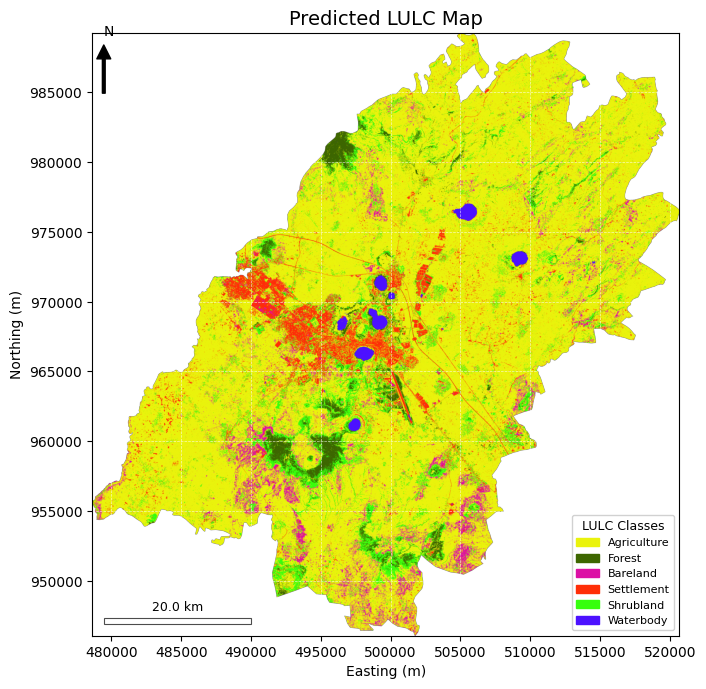

In [12]:
fig, ax = plot_lulc_map(
    lulc_tif= predicted_path,
    class_info=class_info,
    title="Predicted LULC Map",
    legend_loc="lower right",
    enable_scalebar=True,
    scalebar_loc="lower left",
    enable_north_arrow=True,
    north_arrow_loc="upper left",
)

plt.show()

## Create agricultural mask from LULC map 

The agricultural mask creates a `binary mask` that isolates agricultural areas from the LULC classes based on a predefined class value (`AG_CLASS`). 
* The `line agri_mask` = (`lulc_map == AG_CLASS`) generates a Boolean array where pixels classified as agriculture are marked as `True (1)` and all others as `False (0)`.
* The code then checks whether any agricultural pixels were found; if not, it prints a warning message indicating that the specified class (`AG_CLASS`) does not exist in the LULC map.

### Sampling training data for irrigated and rainfed agriculture classification

The code below extracts spectral pixel values from the satellite composite beneath ground control polygons representing `irrigated` and `rainfed` areas. The resulting datasets (`X_irrig`, `y_irrig`) are used to train a machine learning model to distinguish between irrigated and rainfed agricultural areas.

In [13]:
result = irrigation_process(
    lulc_tif=predicted_path,
    ag_class=AG_CLASS,
    gdf_irrig=gdf_irrig,      # polygons with irrig/rainfed labels
    comp_tif=output_composite,        # original composite GeoTIFF
    bands=bands,
    out_masked_tif=agri_masked,
    class_col='class',    # change if needed
)

agri_mask = result["agri_mask"]
masked_comp_tif = result["masked_tif"]
X_irrig = result["X_irrig"]
y_irrig = result["y_irrig"]

[AgriMask] Agricultural pixels: 7,278,151
[AgriMask] Writing masked composite to: Results/agri_masked.tif


Writing masked composite:   0%|          | 0/4316 [00:00<?, ?block/s]

Masked composite written: Results/agri_masked.tif
[Sample] Sampling irrigated/rainfed pixels (agriculture only)...


Sampling polygons:   0%|          | 0/522 [00:00<?, ?poly/s]

[Sample] Done. X: (1049, 6), Labels: [1, 2], Counts: [241, 808]


## Training and Evaluating RF algorithm for irrigated and rainfed mapping 

The RF classifier was used to classify agricultural pixels into `irrigated` and `rainfed` agricultural areas using pixel samples extracted from satellite imagery and GCPs.

* The dataset was split into `training` (`80%`) and `testing` (`20%`).
* key performance metrics, including: `Accuracy score`, `Cohen’s Kappa`, `Confusion matrix`, and `Classification report` were computed.

In [14]:
# --- Sanity check ---------------------------------------------------------------
assert X_irrig.shape[0] > 0, "No irrig/rainfed samples extracted; check GCP geometries & intersection."

# --- Train / test split ---------------------------------------------------------
Xtr_i, Xte_i, ytr_i, yte_i = train_test_split(
    X_irrig, y_irrig, test_size=0.2, random_state=42, stratify=y_irrig
)

# --- Train Random Forest with progress -----------------------------------------
n_estimators = 200
step = 20  # trees added per iteration for smoother progress
rf_irrig = RandomForestClassifier(
    n_estimators=0,   # grow incrementally
    warm_start=True,
    random_state=42,
    n_jobs=-1
)

print("Training irrigated vs rainfed RF...")
built = 0
if tqdm is not None:
    pbar = tqdm(total=n_estimators, desc="Building trees", unit="tree")
else:
    pbar = None

while built < n_estimators:
    add = min(step, n_estimators - built)
    rf_irrig.n_estimators = built + add
    rf_irrig.fit(Xtr_i, ytr_i)
    built += add
    if pbar is not None:
        pbar.update(add)

if pbar is not None:
    pbar.close()

# --- Predict & metrics ----------------------------------------------------------
ypred_i = rf_irrig.predict(Xte_i)

accuracy_i = accuracy_score(yte_i, ypred_i)
kappa_i = cohen_kappa_score(yte_i, ypred_i)
conf_matrix_i = confusion_matrix(yte_i, ypred_i)
report_dict = classification_report(yte_i, ypred_i, output_dict=True)

# Build a clean DataFrame from the classification report
report_df = pd.DataFrame(report_dict).T.rename(columns={
    "precision": "Precision",
    "recall": "Recall",
    "f1-score": "F1-Score",
    "support": "Samples"
})
num_cols = ["Precision", "Recall", "F1-Score"]
report_df[num_cols] = report_df[num_cols].applymap(lambda x: round(x, 3) if isinstance(x, (int, float, np.floating)) else x)
report_df["Samples"] = report_df["Samples"].astype(int)

# Confusion matrix as a labeled DataFrame
classes_sorted = sorted(np.unique(np.concatenate([ytr_i, yte_i])))
cm_df = pd.DataFrame(conf_matrix_i, index=[f"True_{c}" for c in classes_sorted],
                     columns=[f"Pred_{c}" for c in classes_sorted])

# --- Display nicely -------------------------------------------------------------
print("\nIrrigated vs Rainfed RF — Evaluation Summary")
print(f"Overall Accuracy: {accuracy_i*100:.2f}%")
print(f"Cohen’s Kappa: {kappa_i:.3f}\n")

print("Classification Report:")
display(report_df)

print("\nConfusion Matrix:")
display(cm_df)

# --- Optional: feature importances (top 15) ------------------------------------
if hasattr(rf_irrig, "feature_importances_"):
    fi = pd.Series(rf_irrig.feature_importances_)
    # Try to use 'bands' names if available and matches feature count
    if "bands" in globals() and isinstance(bands, (list, tuple)) and len(bands) == fi.shape[0]:
        fi.index = list(bands)
    else:
        fi.index = [f"Band_{i+1}" for i in range(fi.shape[0])]
    fi_df = fi.sort_values(ascending=False).head(min(15, fi.shape[0])).to_frame("Gini Importance")
    print("\nTop Feature Importances:")
    display(fi_df)

Training irrigated vs rainfed RF...


Building trees:   0%|          | 0/200 [00:00<?, ?tree/s]


Irrigated vs Rainfed RF — Evaluation Summary
Overall Accuracy: 94.29%
Cohen’s Kappa: 0.840

Classification Report:


,Precision,Recall,F1-Score,Samples
1,0.860,0.896,0.878,48
2,0.969,0.957,0.963,162
accuracy,0.943,0.943,0.943,0
macro avg,0.914,0.926,0.920,210
weighted avg,0.944,0.943,0.943,210



Confusion Matrix:


,Pred_1,Pred_2
True_1,43,5
True_2,7,155



Top Feature Importances:


,Gini Importance
B02,0.226276
B04,0.223772
B12,0.193153
B11,0.155373
B03,0.123047
B08,0.078379


### Generating irrigated and rainfed agricultural map

This step produces a spatially explicit map of irrigated and rainfed agricultural areas by applying the trained model only to agricultural pixels, creating a georeferenced output ready for analysis or visualization. 

* The code uses the previously created `agri_mask` to locate indices of pixels classified as agriculture. This ensures that `irrigation classification` is applied only within agricultural areas, ignoring `non-agricultural` land.
* The trained `RF` irrigation model (`rf_irrig`) predicts `irrigated` and `rainfed` classes for valid agricultural pixels.
* Saves the map as a GeoTIFF (`irrigated_rainfed.tif`) with georeferencing and spatial metadata intact.

Applying irrigated/rainfed model to agricultural pixels...


Predicting agri blocks:   0%|          | 0/4316 [00:00<?, ?block/s]

Saved irrigated/rainfed map to: Results/irrigated_rainfed.tif


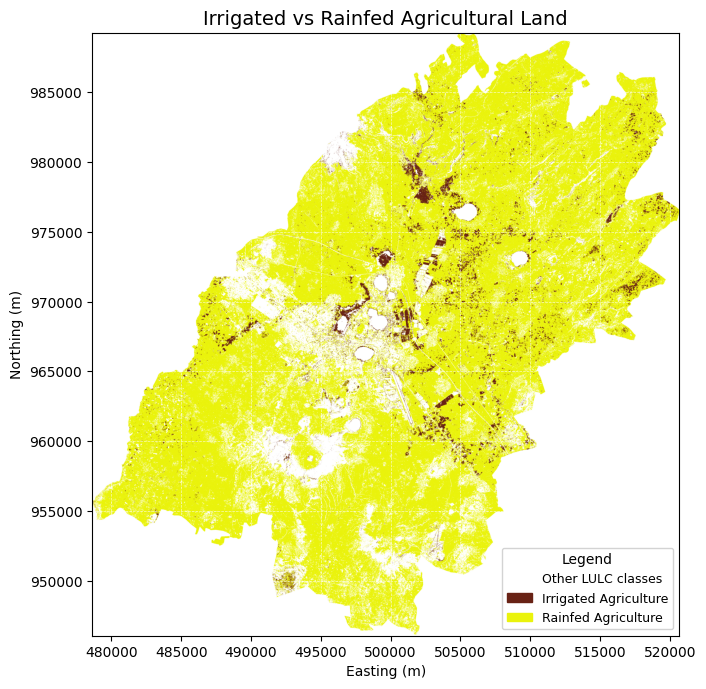

In [15]:
# 1) Predict irrigated/rainfed only inside agri pixels
out_irrig_tif, irrig_map = predict_irrigated_rainfed_map(
    model=rf_irrig,
    comp_tif=output_composite,
    agri_mask=agri_mask,           # boolean mask aligned to comp_tif
    out_path=irrigated_rainfed,
)

# 2) Plot with unified class dict
class_info = {
    0: ("Other LULC classes", "#ffffff"),
    1: ("Irrigated Agriculture", "#682215"),
    2: ("Rainfed Agriculture", "#eaf30c"),
}

fig, ax = plot_irrigated_rainfed_map(
    irrig_tif=out_irrig_tif,
    class_info=class_info,
    title="Irrigated vs Rainfed Agricultural Land",
    legend_loc="lower right",
    grid=True,
)

plt.show()

### Visualizing irrigated and rainfed agricultural areas

This step produces a visually intuitive map of agricultural land, distinguishing irrigated from rainfed areas by creating a `color-coded`, and `georeferenced plot`. 


### Exporting classification accuracy metrics and workflow summary

This code saves the confusion matrices for both LULC and irrigated and rainfed classifications as `CSV` files for reporting and analysis, and provides a summary of all workflow outputs.

### Calculate Area of Irrigated and Rainfed Land
The code below computes the total area of irrigated and rainfed croplands from a classified raster by counting the number of pixels in each class and converting it to hectares.
* `classified_raster`: path to the classified GeoTIFF (`irrigated and rainfed map`).
* `class_mapping`: dictionary linking class values to labels ({`1: Irrigated`, `2: Rainfed`}).
* `pixel_size`: spatial resolution of the raster in meters (`10 m for Sentinel-2`)

In [16]:
class_mapping = {1: "Irrigated", 2: "Rainfed"}

summary_csv = export_classification_summary(
    out_dir="Results",
    y_te=y_te, y_pred_te=y_pred_te,
    yte_i=yte_i, ypred_i=ypred_i,
    accuracy_lulc=accuracy_lulc,
    kappa_lulc=kappa_lulc,
    accuracy_i=accuracy_i,
    kappa_i=kappa_i,
    comp_tif=output_composite,
    out_lulc_tif=predicted_path,
    out_irrig_tif=irrigated_rainfed,
    class_mapping=class_mapping,
    pixel_size=10,
)

print(f"\n Final summary CSV saved at: {summary_csv}")

 Confusion matrices saved in: Results
\  Workflow finished successfully. Outputs:
 - Composite (multiband): Results/composite_multiband.tif
 - LULC map: Results/lulc_map_predicted.tif
 - Rainfed map: Results/irrigated_rainfed.tif
 - LULC confusion CSV: Results/lulc_confusion_matrix.csv
 - Irrigated/Rainfed confusion CSV: Results/irrig_confusion_matrix.csv
 - Unified Area+Metrics CSV: Results/area_summary.csv

 Area + metrics summary:
    Class  Area_ha  Percent  Acc_LULC  Kappa_LULC  Acc_Irrig  Kappa_Irrig
Irrigated  3285.10     4.51    0.9119      0.8798     0.9429       0.8403
  Rainfed 69496.41    95.49    0.9119      0.8798     0.9429       0.8403

 Final summary CSV saved at: Results/area_summary.csv


### Comparison of the IWMI and Predicted Irrigated Mapping

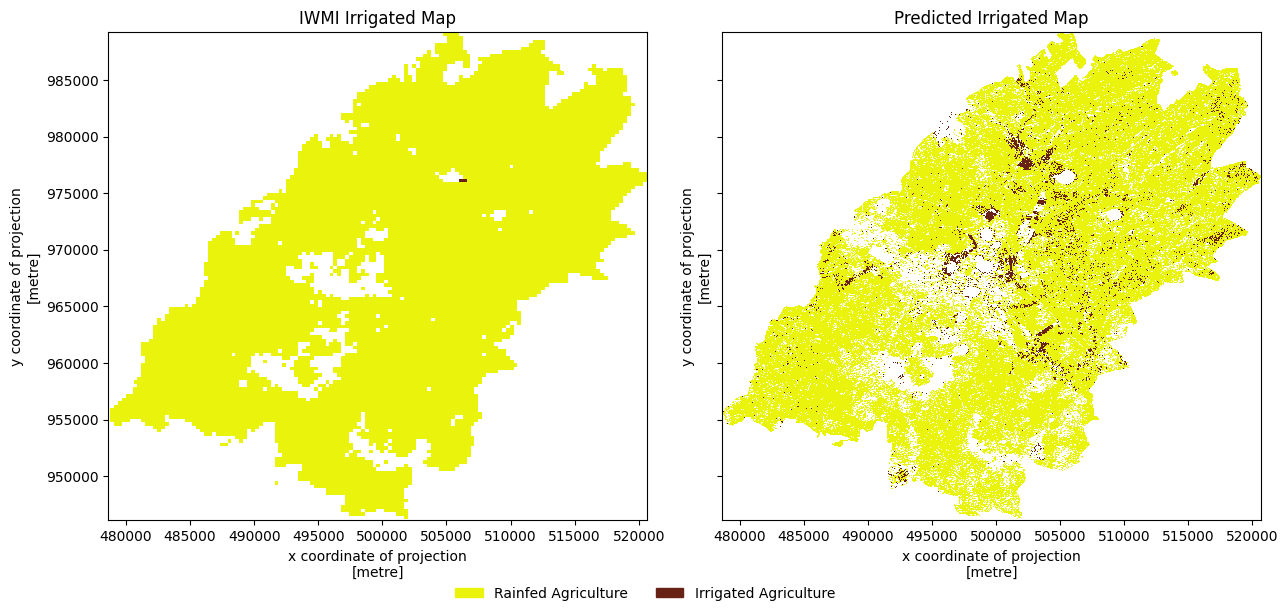

In [17]:
class_info_pred = {
    1: ("Irrigated Agriculture", "#682215"),
    2: ("Rainfed Agriculture", "#eaf30c"),
}

class_info_iwmi = {
    1: ("Irrigated Agriculture", "#682215"),
    0: ("Rainfed Agriculture", "#eaf30c"),
}

out = compare_map(
    other_map_path_or_url=f"{irrigated_rainfed}.tif",
    aoi_path=roi_path,
    iwmi_url_or_path=None,  # auto-pick first IWMI raster from S3
    resampling_for_align="nearest",
    class_info_pred=class_info_pred,
    class_info_iwmi=class_info_iwmi,
    title_iwmi="IWMI Irrigated Map",
    title_pred="Predicted Irrigated Map",
)